# 3. Train-Predict

**Result:**
- Kaggle score: 

**Tensorboard**
- Input at command: tensorboard --logdir=./log
- Input at browser: http://127.0.0.1:6006

In [1]:
import time
import os
import pandas as pd

project_name = 'Dog_Breed_Identification'
step_name = 'Train-Predict'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('log_path: \t' + log_path)
print('model_path: \t' + model_path)
print('output_path: \t' + output_path)

run_name: Dog_Breed_Identification_Train-Predict_20180223_134540
log_path: 	D:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log
model_path: 	D:\Udacity\MachineLearning(Advanced)\p6_graduation_project\model
output_path: 	D:\Udacity\MachineLearning(Advanced)\p6_graduation_project\output


In [2]:
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

x_train = []
y_train = {}
x_val = []
y_val = {}
x_test = []

cwd = os.getcwd()
# feature_cgg16 = os.path.join(cwd, 'model', 'feature_VGG16_{}.h5'.format(20180219))
# feature_cgg19 = os.path.join(cwd, 'model', 'feature_VGG19_{}.h5'.format(20180219))
# feature_resnet50 = os.path.join(cwd, 'model', 'feature_ResNet50_{}.h5'.format(20180220))
feature_xception = os.path.join(cwd, 'model', 'feature_Xception_{}.h5'.format(20180221))
feature_inception = os.path.join(cwd, 'model', 'feature_InceptionV3_{}.h5'.format(20180221))
feature_inceptionResNetV2 = os.path.join(cwd, 'model', 'feature_InceptionResNetV2_{}.h5'.format(20180221))
# for filename in [feature_cgg16, feature_cgg19, feature_resnet50, feature_xception, feature_inception, feature_inceptionResNetV2]:
for filename in [feature_xception, feature_inception, feature_inceptionResNetV2]:
# for filename in [feature_inception]:
    with h5py.File(filename, 'r') as h:
        x_train.append(np.array(h['train']))
        y_train = np.array(h['train_labels'])
        x_val.append(np.array(h['val']))
        y_val = np.array(h['val_labels'])
        x_test.append(np.array(h['test']))

# print(x_train[0].shape)
x_train = np.concatenate(x_train, axis=-1)
# y_train = np.concatenate(y_train, axis=0)
x_val = np.concatenate(x_val, axis=-1)
# y_val = np.concatenate(y_val, axis=0)
x_test = np.concatenate(x_test, axis=-1)
print(x_train.shape)
print(x_train.shape[1:])
print('-' * 10)

print(x_train.shape)
print(len(y_train))
print(x_val.shape)
print(len(y_val))
print(x_test.shape)

(30290, 5632)
(5632,)
----------
(30290, 5632)
30290
(512, 5632)
512
(10357, 5632)


In [4]:
from sklearn.utils import shuffle
(x_train, y_train) = shuffle(x_train, y_train)

In [5]:
from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.025, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(30290, 5632)
(30290,)
(512, 5632)
(512,)


In [6]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)

Using TensorFlow backend.


(30290, 120)
(512, 120)


### Build CNN

In [7]:
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [8]:
def get_lr(x):
    lr = round(3e-4 * 0.96 ** x, 10)
    if lr < 1e-8:
        lr = 1e-8
    print('%.12f' % lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log\Dog_Breed_Identification_Train-Predict_20180223_134540


In [9]:
model = Sequential()
model.add(Dense(4096, input_shape=x_train.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='sigmoid'))
model.add(Dropout(0.3))
# model.add(Dense(1024, activation='sigmoid'))
# model.add(Dropout(0.3))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              23072768  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               491640    
Total para

In [11]:
hist = model.fit(x_train, y_train,
                 batch_size=256,
                 epochs=300, #Increase this when not on Kaggle kernel
                 verbose=1,  #1 for ETA, 0 for silent
                 callbacks=[annealer],
                 validation_data=(x_val, y_val))

Train on 30290 samples, validate on 512 samples
0.000300000000  Epoch 1/300
30290/30290 [==============================] - 103s 3ms/step - loss: 1.2248 - acc: 0.7437 - val_loss: 0.3038 - val_acc: 0.9043
0.000288000000  Epoch 2/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.2692 - acc: 0.9208 - val_loss: 0.2561 - val_acc: 0.9297
0.000276480000  Epoch 3/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.2186 - acc: 0.9336 - val_loss: 0.2057 - val_acc: 0.9395
0.000265420800  Epoch 4/300
30290/30290 [==============================] - 103s 3ms/step - loss: 0.1937 - acc: 0.9409 - val_loss: 0.2051 - val_acc: 0.9375
0.000254804000  Epoch 5/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.1690 - acc: 0.9469 - val_loss: 0.1798 - val_acc: 0.9512
0.000244611800  Epoch 6/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.1460 - acc: 0.9538 - val_loss: 0.1688 - val_acc: 0.9473
0.000234827300  Epoch 

30290/30290 [==============================] - 102s 3ms/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0076 - val_acc: 0.9980
0.000034474400  Epoch 54/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0120 - val_acc: 0.9961
0.000033095400  Epoch 55/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0058 - acc: 0.9980 - val_loss: 0.0135 - val_acc: 0.9961
0.000031771600  Epoch 56/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0059 - acc: 0.9977 - val_loss: 0.0091 - val_acc: 0.9961
0.000030500700  Epoch 57/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0068 - acc: 0.9976 - val_loss: 0.0128 - val_acc: 0.9961
0.000029280700  Epoch 58/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0056 - acc: 0.9979 - val_loss: 0.0109 - val_acc: 0.9941
0.000028109500  Epoch 59/300
30290/30290 [==============================] - 102s 3ms/step - l

30290/30290 [==============================] - 102s 3ms/step - loss: 0.0037 - acc: 0.9981 - val_loss: 0.0076 - val_acc: 0.9941
0.000004126700  Epoch 106/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0034 - acc: 0.9983 - val_loss: 0.0077 - val_acc: 0.9941
0.000003961600  Epoch 107/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0034 - acc: 0.9982 - val_loss: 0.0079 - val_acc: 0.9941
0.000003803100  Epoch 108/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0036 - acc: 0.9983 - val_loss: 0.0076 - val_acc: 0.9941
0.000003651000  Epoch 109/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0037 - acc: 0.9980 - val_loss: 0.0073 - val_acc: 0.9941
0.000003505000  Epoch 110/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0031 - acc: 0.9986 - val_loss: 0.0083 - val_acc: 0.9941
0.000003364800  Epoch 111/300
30290/30290 [==============================] - 102s 3ms/st

30290/30290 [==============================] - 102s 3ms/step - loss: 0.0029 - acc: 0.9986 - val_loss: 0.0080 - val_acc: 0.9941
0.000000494000  Epoch 158/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0030 - acc: 0.9984 - val_loss: 0.0081 - val_acc: 0.9941
0.000000474200  Epoch 159/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0032 - acc: 0.9984 - val_loss: 0.0082 - val_acc: 0.9941
0.000000455200  Epoch 160/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0081 - val_acc: 0.9941
0.000000437000  Epoch 161/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0035 - acc: 0.9982 - val_loss: 0.0081 - val_acc: 0.9941
0.000000419600  Epoch 162/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0028 - acc: 0.9986 - val_loss: 0.0082 - val_acc: 0.9941
0.000000402800  Epoch 163/300
30290/30290 [==============================] - 102s 3ms/st

30290/30290 [==============================] - 102s 3ms/step - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0081 - val_acc: 0.9941
0.000000059100  Epoch 210/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0029 - acc: 0.9985 - val_loss: 0.0081 - val_acc: 0.9941
0.000000056800  Epoch 211/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0033 - acc: 0.9984 - val_loss: 0.0081 - val_acc: 0.9941
0.000000054500  Epoch 212/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0029 - acc: 0.9987 - val_loss: 0.0081 - val_acc: 0.9941
0.000000052300  Epoch 213/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0032 - acc: 0.9983 - val_loss: 0.0081 - val_acc: 0.9941
0.000000050200  Epoch 214/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0032 - acc: 0.9983 - val_loss: 0.0081 - val_acc: 0.9941
0.000000048200  Epoch 215/300
30290/30290 [==============================] - 102s 3ms/st

30290/30290 [==============================] - 102s 3ms/step - loss: 0.0029 - acc: 0.9985 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 262/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0030 - acc: 0.9984 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 263/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0029 - acc: 0.9987 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 264/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0030 - acc: 0.9985 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 265/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0031 - acc: 0.9985 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 266/300
30290/30290 [==============================] - 102s 3ms/step - loss: 0.0030 - acc: 0.9985 - val_loss: 0.0080 - val_acc: 0.9941
0.000000010000  Epoch 267/300
30290/30290 [==============================] - 102s 3ms/st

In [12]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

512/512 [==============================] - 0s 820us/step
Final loss: 0.0080, final accuracy: 0.9941


In [13]:
run_name_acc = run_name + '_' + str(int(final_loss*10000)).zfill(4)

In [14]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


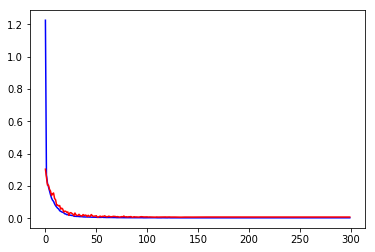

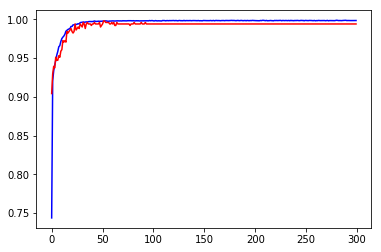

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, run_name_acc)

## Predict

In [17]:
# Used to load model directly and skip train
# import os
# from keras.models import load_model
# cwd = os.getcwd()
# model = load_model(os.path.join(cwd, 'model', 'Dog_Breed_Identification_Train_20171024_155154.h5'))

In [18]:
y_pred = model.predict(x_test, batch_size=128)
print(y_pred.shape)

(10357, 120)


In [19]:
# print(y_pred[:10])
# y_pred = np.clip(y_pred, 0.005, 0.995)
# print(y_pred[:10])

In [20]:
files = os.listdir(os.path.join(cwd, 'input', 'data_test', 'test'))
print(files[:10])

['000621fb3cbb32d8935728e48679680e.jpg', '00102ee9d8eb90812350685311fe5890.jpg', '0012a730dfa437f5f3613fb75efcd4ce.jpg', '001510bc8570bbeee98c8d80c8a95ec1.jpg', '001a5f3114548acdefa3d4da05474c2e.jpg', '00225dcd3e4d2410dd53239f95c0352f.jpg', '002c2a3117c2193b4d26400ce431eebd.jpg', '002c58d413a521ae8d1a5daeb35fc803.jpg', '002f80396f1e3db687c5932d7978b196.jpg', '0036c6bcec6031be9e62a257b1c3c442.jpg']


In [21]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [22]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))
print(breed)

{'miniature_schnauzer', 'wire-haired_fox_terrier', 'norfolk_terrier', 'bluetick', 'sealyham_terrier', 'norwich_terrier', 'gordon_setter', 'miniature_poodle', 'bernese_mountain_dog', 'pug', 'dhole', 'toy_terrier', 'toy_poodle', 'tibetan_terrier', 'siberian_husky', 'keeshond', 'blenheim_spaniel', 'chihuahua', 'whippet', 'basenji', 'great_pyrenees', 'bedlington_terrier', 'west_highland_white_terrier', 'rhodesian_ridgeback', 'borzoi', 'entlebucher', 'kerry_blue_terrier', 'chesapeake_bay_retriever', 'brabancon_griffon', 'english_springer', 'irish_water_spaniel', 'french_bulldog', 'standard_poodle', 'cardigan', 'soft-coated_wheaten_terrier', 'scottish_deerhound', 'flat-coated_retriever', 'silky_terrier', 'black-and-tan_coonhound', 'german_short-haired_pointer', 'brittany_spaniel', 'weimaraner', 'mexican_hairless', 'pekinese', 'boxer', 'shih-tzu', 'welsh_springer_spaniel', 'saluki', 'cairn', 'schipperke', 'pomeranian', 'doberman', 'sussex_spaniel', 'scotch_terrier', 'english_setter', 'african

In [23]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
print(df2.shape)

(10357, 121)


In [24]:
print(y_pred.shape)

(10357, 120)


In [25]:
for i in range(0, 120):
    df2.iloc[:,[i+1]] = y_pred[:,i]
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, 'pred_' + run_name_acc + '.csv')
df2.to_csv(pred_file, index=None)

In [26]:
print(run_name_acc)
print('Done !')

Dog_Breed_Identification_Train-Predict_20180223_134540_0080
Done !
